## Imports

In [ ]:
import os
import time
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Un-tar the saved model

In [ ]:
!tar -xvf "/content/zero-dce-saved-model.tar"

content/zero-dce-saved-model/
content/zero-dce-saved-model/assets/
content/zero-dce-saved-model/variables/
content/zero-dce-saved-model/variables/variables.index
content/zero-dce-saved-model/variables/variables.data-00000-of-00001
content/zero-dce-saved-model/keras_metadata.pb
content/zero-dce-saved-model/saved_model.pb


## Data Gathering

In [ ]:
!gdown https://drive.google.com/uc?id=1DdGIJ4PZPlF2ikl8mNM9V-PdVxVLbQi6
!unzip -q lol_dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1DdGIJ4PZPlF2ikl8mNM9V-PdVxVLbQi6
To: /content/lol_dataset.zip
347MB [00:01, 231MB/s]


In [ ]:
SAVED_MODEL_FILE = 'zero-dce-saved-model/'
TFLITE_MODEL_FILE = 'zero-dce.tflite'

## Convert the model into TF-Lite

In [ ]:
model = keras.models.load_model(SAVED_MODEL_FILE)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(TFLITE_MODEL_FILE, 'wb').write(tflite_model)

print('Model size is %f MBs.' % (len(tflite_model) / 1024 / 1024.0))

INFO:tensorflow:Assets written to: /tmp/tmpec_irk13/assets


INFO:tensorflow:Assets written to: /tmp/tmpec_irk13/assets


Model size is 0.319515 MBs.


## Check Tensor-Shape

In [ ]:
interpreter = tf.lite.Interpreter(model_path = TFLITE_MODEL_FILE)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 400 600   3]
Input Type: <class 'numpy.float32'>
Output Shape: [  1 400 600   3]
Output Type: <class 'numpy.float32'>


In [ ]:
@tf.function
def load_images(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3, expand_animations = False)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (400, 600))
    return image

In [ ]:
test_image_paths = (list(paths.list_images("test")))
print(f"Total test images: {len(test_image_paths)}")

Total test images: 3


In [ ]:
test_ds = tf.data.Dataset.from_tensor_slices(test_image_paths)
test_ds = (
    test_ds
    .map(load_images)
    .batch(2)
)

In [ ]:
test_imgs = next(iter(test_ds))
print(test_imgs.shape)

(2, 400, 600, 3)


## Resize the Tensor shape

In [ ]:
interpreter.resize_tensor_input(input_details[0]['index'], (2, 400, 600, 3))
interpreter.resize_tensor_input(output_details[0]['index'], (2, 400, 600, 3))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  2 400 600   3]
Input Type: <class 'numpy.float32'>
Output Shape: [  2 400 600   3]
Output Type: <class 'numpy.float32'>


## Making Inference

In [ ]:
start_time= time.clock()
interpreter.set_tensor(input_details[0]['index'], test_imgs)
interpreter.invoke()
end_time = time.clock() - start_time

tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])

print("Prediction results shape:", tflite_model_predictions.shape)
print("End Time", (end_time/2))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


Prediction results shape: (2, 400, 600, 3)
End Time 1.3819044999999992


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


In [ ]:
def show_image(image_array, mode='Input'):
    image = keras.preprocessing.image.array_to_img(image_array)
    plt.figure(figsize=(10, 10))
    plt.title(mode)
    plt.imshow(image)

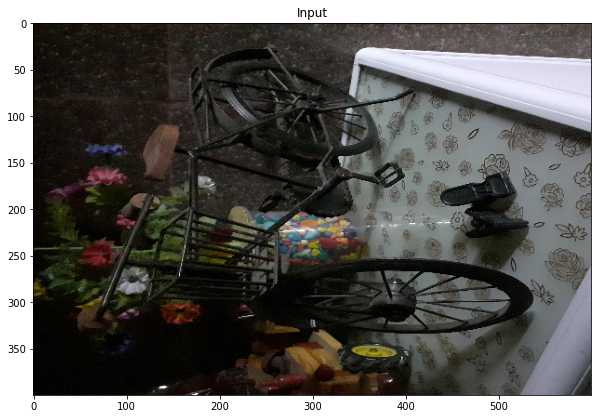

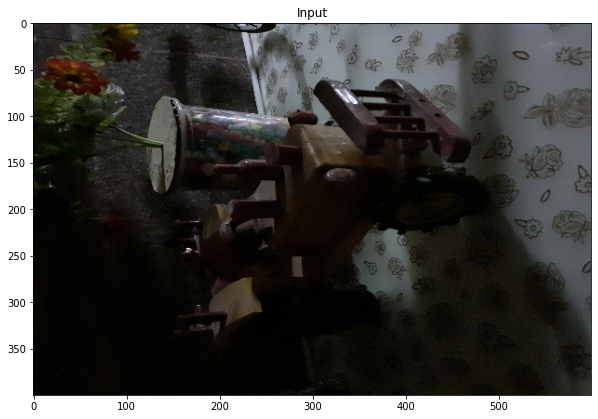

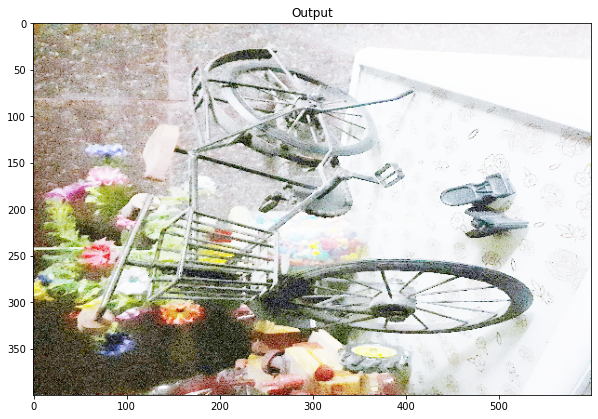

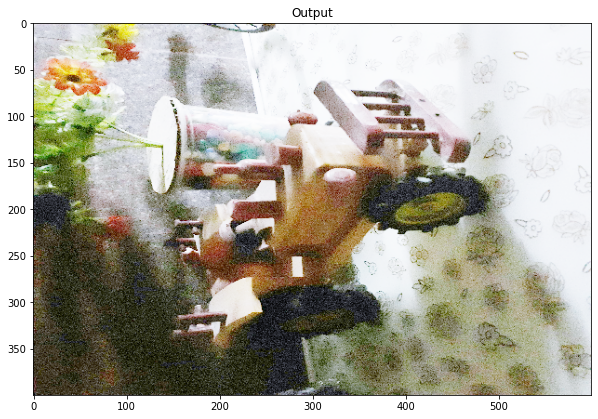

In [ ]:
show_image(test_imgs[0])
show_image(test_imgs[1])
show_image(tflite_model_predictions[0], mode='Output')
show_image(tflite_model_predictions[1], mode='Output')